# How does the zebrafish spinal cord develop?
#### We'll detect networks that show how spinal cord neurons synchronize over the course of embroynic development.

In [1]:
%matplotlib inline
import covdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

## Load and visualize data
#### Thanks to Yinan Wang and Philipp Keller at Janelia!

In [41]:
d = np.load('/Users/ClaraFannjiang/code/zebra_dev.npz')
data = d['data']
coords = d['coords']
n_left = d['n_left']
n_right = d['n_right']
n_samp = data.shape[1]
hz = float(4) # sampling rate in Hz

#### Visualize anatomical positions of neurons

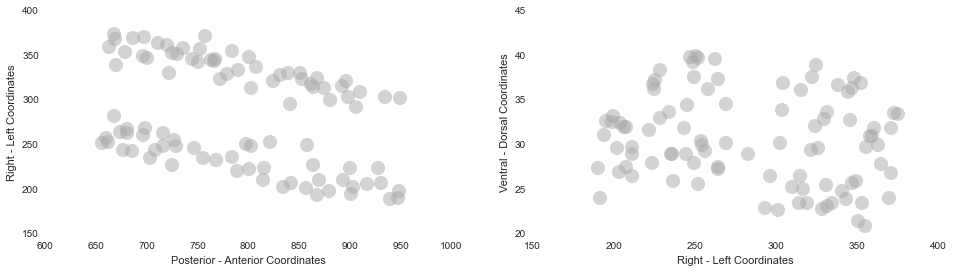

In [93]:
sns.set(rc={'axes.facecolor':'white', 'axes.grid':'off'})
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.scatter(coords[:, -1, 0], coords[:, -1, 1], s=200, linewidth=0, alpha=0.5, c='DarkGray');
plt.xlabel('Posterior - Anterior Coordinates');
plt.ylabel('Right - Left Coordinates');
plt.subplot(122);
plt.scatter(coords[:, -1, 1], coords[:, -1, 2], s=200, linewidth=0, alpha=0.5, c='DarkGray');
plt.xlabel('Right - Left Coordinates');
plt.ylabel('Ventral - Dorsal Coordinates');

#### Plot activity of example neurons

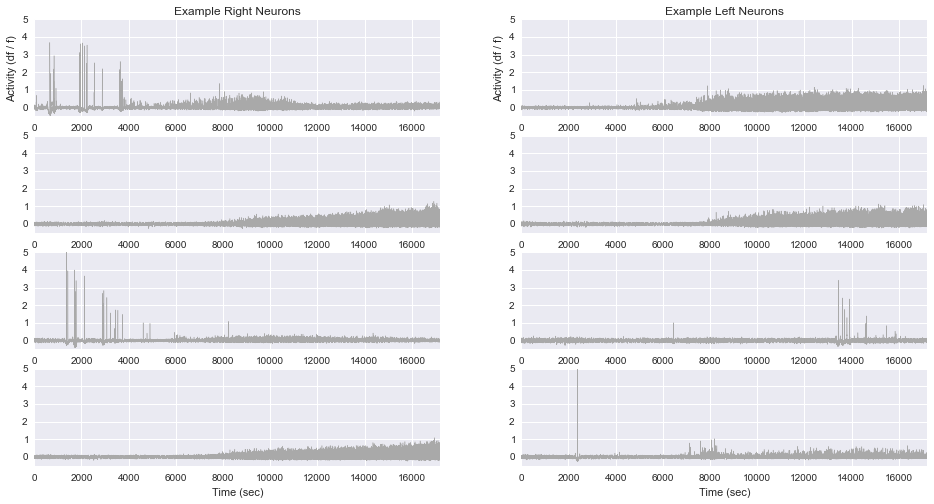

In [146]:
sns.set_style('darkgrid')
n = 4 # number of example neurons on each side
plt.figure(figsize=(16, 2 * n));
t = np.arange(n_samp) / hz

right_idx = np.argsort(np.std(data[: n_right, :], axis=1))[::-1][: n] # most active right neurons
left_idx = np.argsort(np.std(data[n_right :, :], axis=1))[::-1][: n] # most active left neurons

for i in range(n):
    plt.subplot(n, 2, 2 * i + 1);
    plt.plot(t, data[right_idx[i], :].T, linewidth=0.5, c='DarkGray');
    plt.xlim(0, n_samp / hz);
    plt.ylim(-0.5, 5);
    
    plt.subplot(n, 2, 2 * (i + 1));
    plt.plot(t, data[n_right + left_idx[i], :].T, linewidth=0.5, c='DarkGray');
    plt.xlim(0, n_samp / hz);
    plt.ylim(-0.5, 5);

plt.subplot(n, 2, 1); plt.title('Example Right Neurons'); plt.ylabel('Activity (df / f)'); 
plt.subplot(n, 2, 2); plt.title('Example Left Neurons'); plt.ylabel('Activity (df / f)');
plt.subplot(n, 2, 2 * n - 1); plt.xlabel('Time (sec)'); plt.subplot(n, 2, 2 * n); plt.xlabel('Time (sec)');

#### From these individual plots alone, it's hard to see what relationships are forming between neurons.

## Detect networks that change over development

#### Compute sample correlation matrices over time

In [107]:
window = 1 * 60 * hz # window size = minutes x 60 seconds per minute x sampling rate
n_window = int(n_samp / window)
X = np.dstack([np.corrcoef(data[:, i : i + window]) for i in np.arange(0, n_samp, window)])

#### Run algorithm

In [108]:
k = 2
cd = covdict.CovarianceDictionary(k=k, method='admm', correlation=True, verbose=True)
weights = cd.fit_transform(X)

Iter: 0. Objective: 0.656172.
Iter: 100. Objective: 0.568145.
Iter: 134. Objective: 0.567355.


#### Plot weights learned by algorithm, which give the strengths of two different networks over time

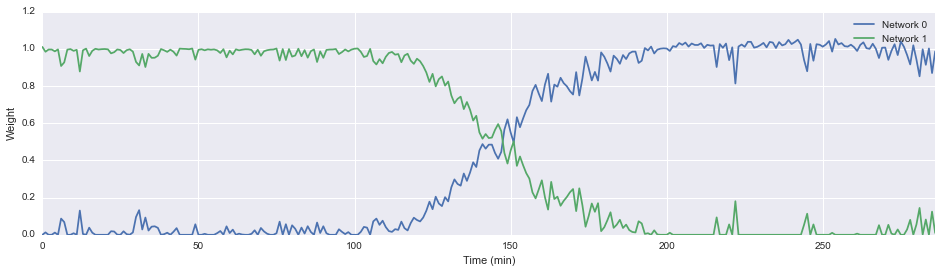

In [109]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));
plt.plot(weights.T);
plt.xlim(0, n_window);
plt.xlabel('Time (min)');
plt.ylabel('Weight');
plt.legend(['Network ' + str(i) for i in range(k)]);

#### Development seems to be characterized by two distinct stages. What does the network at each stage look like?

## Visualize networks

#### Networks are represented by matrices where the (i, j)-th entry gives the correlation coefficient between the i-th and j-th neurons

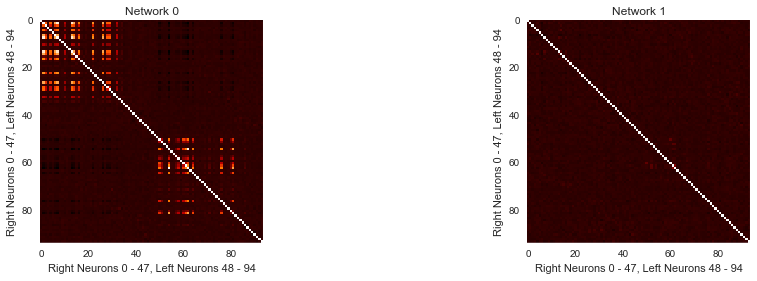

In [140]:
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

vmin = np.min(cd.dictionary)
vmax = np.max(cd.dictionary)

for i in range(k):
    plt.subplot(1, k, i + 1)   
    plt.imshow(cd.dictionary.T[i], interpolation='None', cmap='gist_heat', vmin=vmin, vmax=vmax);
    plt.xlabel('Right Neurons 0 - {}, Left Neurons {} - {}'.format(n_right, n_right + 1, n_right + n_left));
    plt.ylabel('Right Neurons 0 - {}, Left Neurons {} - {}'.format(n_right, n_right + 1, n_right + n_left));
    plt.title('Network ' + str(i));

#### Visualize networks as graphs, where green edges link correlated neurons, red edges link anti-correlated neurons, and edge width gives correlation magnitude.

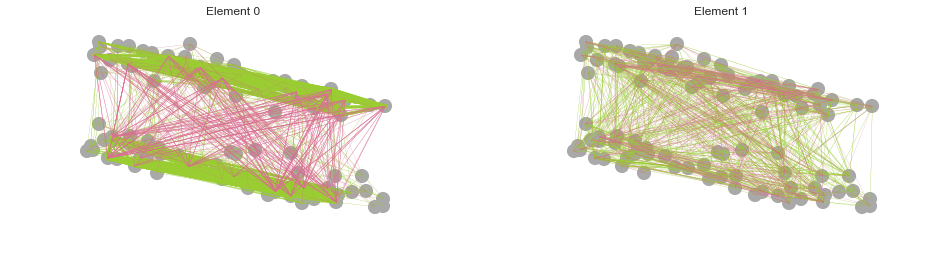

In [160]:
reload(covdict)
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

for i in range(k):
    plt.subplot(1, k, i + 1);
    covdict.plot_element(cd.dictionary.T[i], coords[:, -1, [0, 1]], thresh=0.8);
    plt.title('Element ' + str(i));

#### In the first half of development, there is no clear pattern of which neurons are correlated to each other. As development progresses, however, neurons on each side of the spinal cord become 1) more correlated to neurons on the same side and 2) more anti-correlated to neurons on the opposite side.